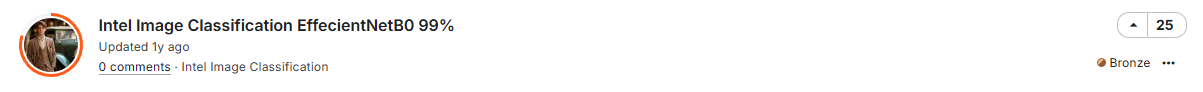

In [1]:
#os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay

#Deep learnings tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = 'D:\code_study\ML_CODE\dataSets\IntelImageClassification\seg_train\seg_train'
test_data = 'D:\code_study\ML_CODE\dataSets\IntelImageClassification\seg_test\seg_test'

filepath= []
label =[]

folds = os.listdir(train_data)

for fold in folds:
    f_path = os.path.join(train_data , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
train_df = pd.concat([fseries , lseries] , axis = 1)

In [3]:
train_df

,filepaths,labels
0,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
1,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
2,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
3,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
4,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
...,...,...
14029,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
14030,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
14031,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
14032,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street


In [4]:
folds = os.listdir(test_data)

for fold in folds:
    f_path = os.path.join(test_data , fold)
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
ts_df = pd.concat([fseries , lseries] , axis = 1)

In [5]:
ts_df

,filepaths,labels
0,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
1,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
2,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
3,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
4,D:\code_study\ML_CODE\dataSets\IntelImageClass...,buildings
...,...,...
17029,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
17030,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
17031,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street
17032,D:\code_study\ML_CODE\dataSets\IntelImageClass...,street


In [6]:
valid , test = train_test_split(ts_df , test_size= 0.5 , shuffle = True , random_state = 42)
print(f"Shape of Validation set is: {valid.shape}")
print(f"Shape of Test set is: {test.shape}")

Shape of Validation set is: (8517, 2)
Shape of Test set is: (8517, 2)


In [7]:
img_size = (150 ,150)
batch_size = 32

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 14034 validated image filenames belonging to 6 classes.
Found 8517 validated image filenames belonging to 6 classes.
Found 8517 validated image filenames belonging to 6 classes.


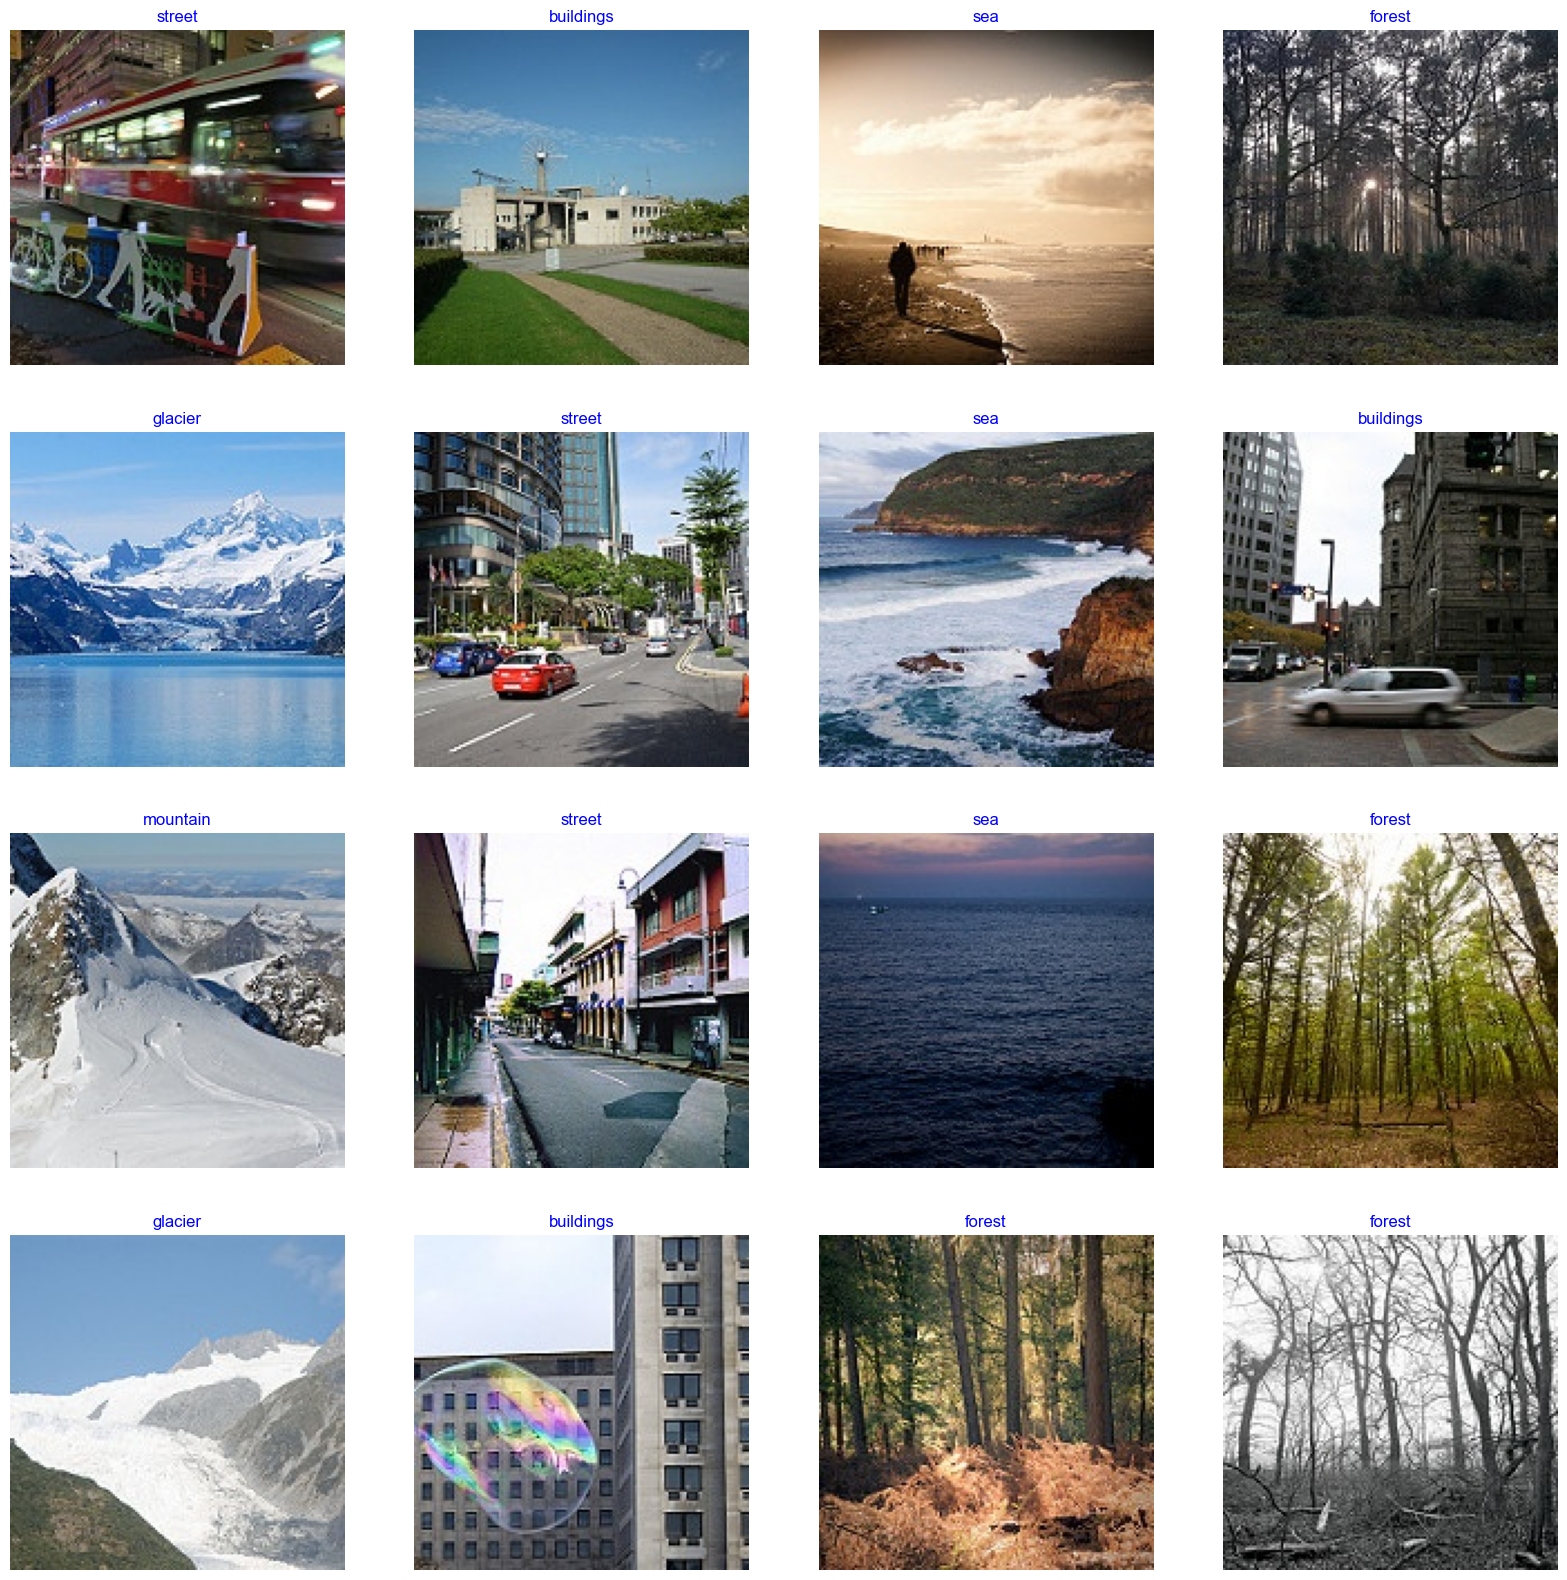

In [8]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [9]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 4,449,961
Trainable params: 4,405,378
Non-trainable params: 44,583
_________________________________________________________________


In [10]:
epochs = 10

history = model.fit(x = train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False , workers=5)

Epoch 1/10
439/439 [==============================] - 175s 385ms/step - loss: 0.5023 - accuracy: 0.8166 - val_loss: 0.1269 - val_accuracy: 0.9605
Epoch 2/10
439/439 [==============================] - 139s 314ms/step - loss: 0.1477 - accuracy: 0.9496 - val_loss: 0.0861 - val_accuracy: 0.9732
Epoch 3/10
439/439 [==============================] - 84s 191ms/step - loss: 0.1002 - accuracy: 0.9653 - val_loss: 0.0749 - val_accuracy: 0.9772
Epoch 4/10
439/439 [==============================] - 84s 191ms/step - loss: 0.0666 - accuracy: 0.9758 - val_loss: 0.0550 - val_accuracy: 0.9858
Epoch 5/10
439/439 [==============================] - 83s 190ms/step - loss: 0.0493 - accuracy: 0.9837 - val_loss: 0.0506 - val_accuracy: 0.9884
Epoch 6/10
439/439 [==============================] - 83s 189ms/step - loss: 0.0339 - accuracy: 0.9884 - val_loss: 0.0474 - val_accuracy: 0.9870
Epoch 7/10
439/439 [==============================] - 83s 190ms/step - loss: 0.0297 - accuracy: 0.9894 - val_loss: 0.0637 - val_

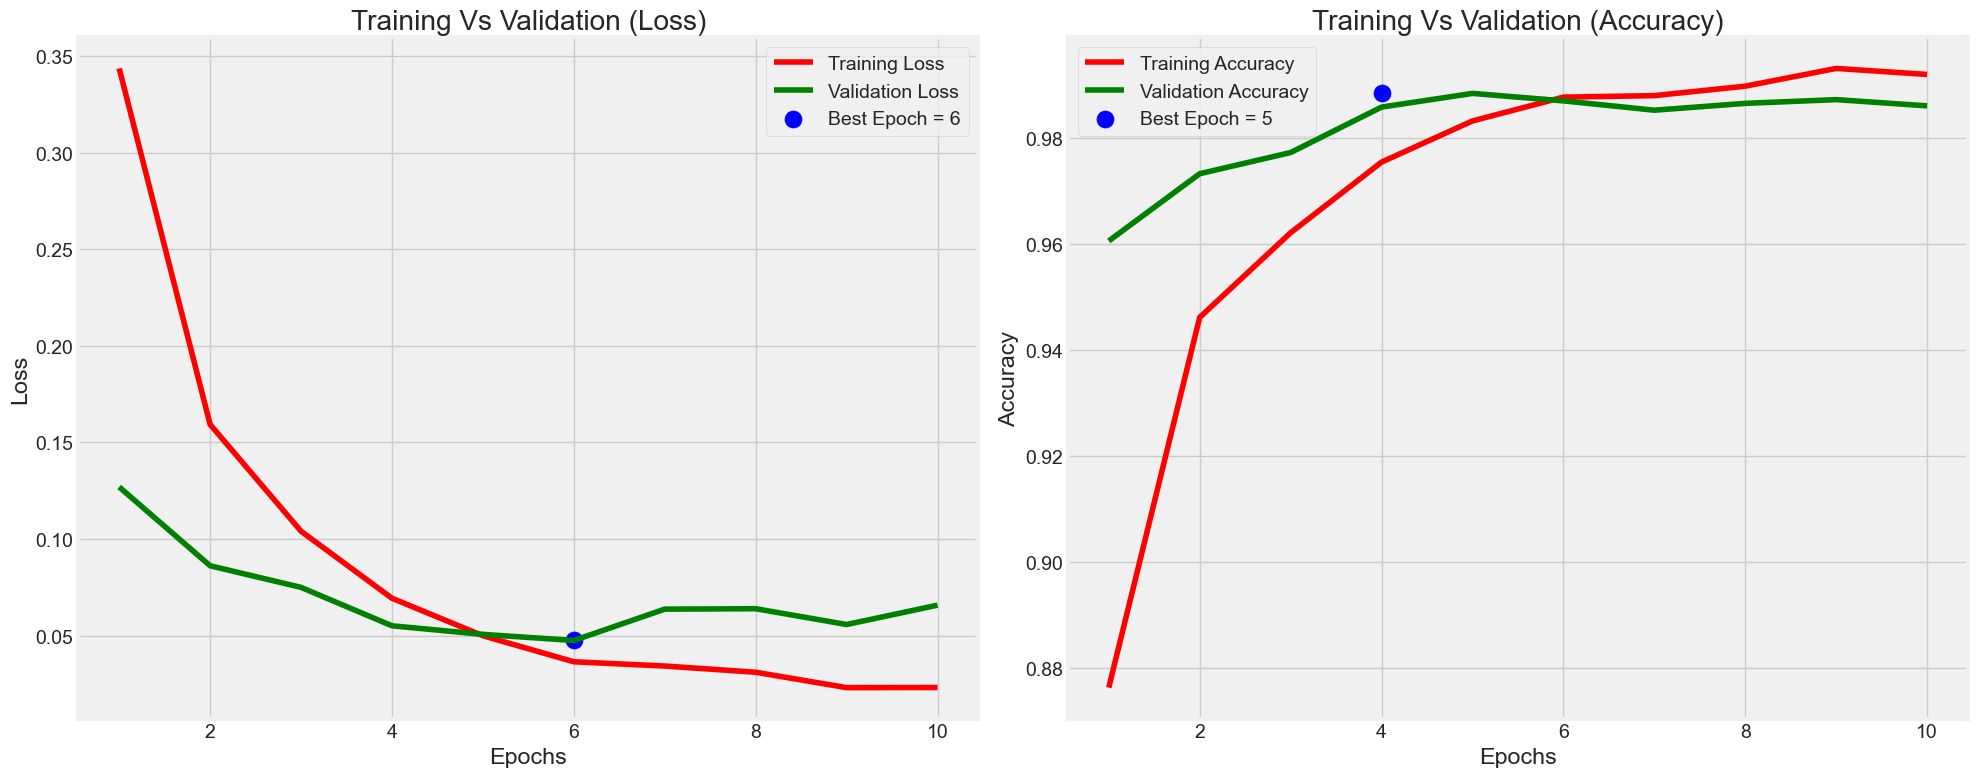

In [11]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

In [12]:
train_score = model.evaluate(train_gen , steps = 32 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

32/32 [==============================] - 2s 47ms/step - loss: 0.0597 - accuracy: 0.9854
Train Loss:  0.0032091643661260605
Train Accuracy:  0.998046875
--------------------
Validation Loss:  0.06162605434656143
Validation Accuracy:  0.9853515625
--------------------
Test Loss:  0.059710435569286346
Test Accuracy:  0.9853515625


In [13]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

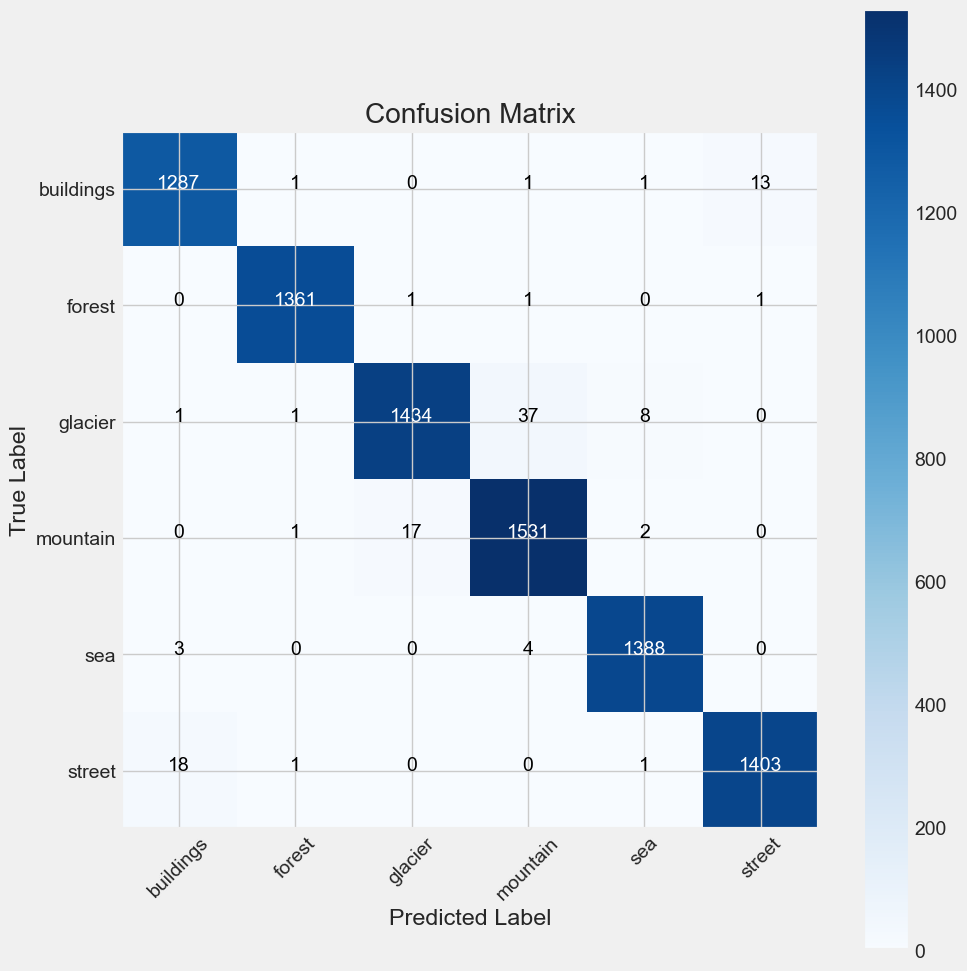

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))